In [4]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import pandas as pd
import jdatetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("/home/ccp/Desktop/task1/Stores_Transactions .csv")
# Function to convert Shamsi dates to Gregorian dates
def convert_shamsi_to_gregorian(shamsi_date):
    year, month, day = map(int, shamsi_date.split('-'))
    gregorian_date = jdatetime.date(year, month, day).togregorian()
    return pd.to_datetime(gregorian_date)

# Apply the conversion function to the transaction_date column
df['transaction_date'] = df['transaction_date'].apply(convert_shamsi_to_gregorian)

# Proceed with the rest of your preprocessing and model training
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df['day'] = df['transaction_date'].dt.day
df['day_of_week'] = df['transaction_date'].dt.weekday

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['store', 'product_name'], drop_first=True)

# Features and target variable
X = df[['year', 'month', 'day', 'day_of_week'] + [col for col in df.columns if 'store' in col or 'product_name' in col]]
y = df['quantity']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initializing MinMaxScaler
scaler = MinMaxScaler()

# Fitting on training data and transforming both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression Model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for Linear Regression: {mae}')


Mean Absolute Error for Linear Regression: 2.1713218084669834


In [10]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_regressor.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error for Random Forest: {mae_rf}')

Mean Absolute Error for Random Forest: 2.0233404950753946


In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM (assuming you want to forecast total demand)
df_grouped = df.groupby(['transaction_date'])['quantity'].sum().reset_index()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_grouped[['quantity']])

# Create time-series sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # 30 days for time series forecasting
X_data, y_data = create_sequences(scaled_data, seq_length)

# Train-test split
X_train, X_test = X_data[:int(0.8*len(X_data))], X_data[int(0.8*len(X_data)):]
y_train, y_test = y_data[:int(0.8*len(y_data))], y_data[int(0.8*len(y_data)):]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(32))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16)

# Predictions and evaluation
y_pred_lstm = model.predict(X_test)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)         

/home/ccp/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.1325
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0493
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0348
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0393
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0328
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0409
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0383
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0358
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0371
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0412
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0351
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0376
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0352
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0323
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - lo

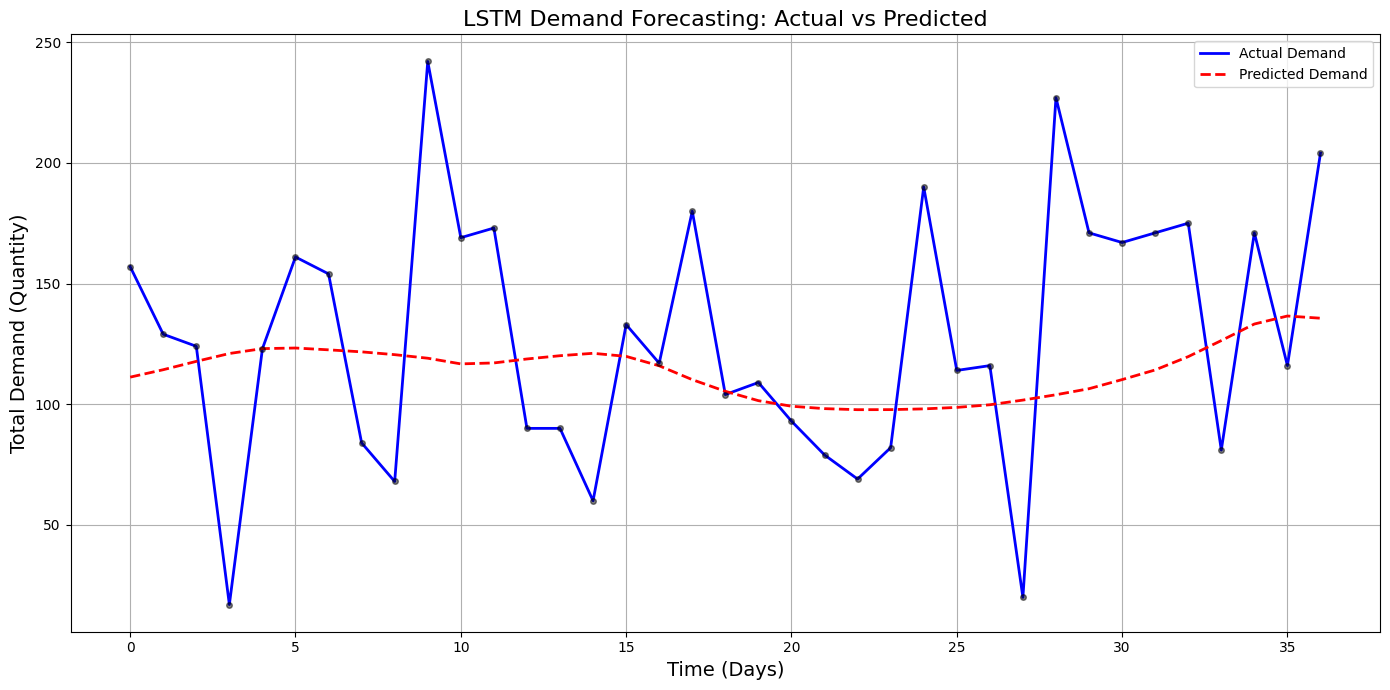

In [24]:
import matplotlib.pyplot as plt

# Inverse transform the actual test values (y_test)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted demand
plt.figure(figsize=(14, 7))

# Plotting the actual values (for test data)
plt.plot(y_test_rescaled, label="Actual Demand", color='blue', linestyle='-', linewidth=2)

# Plotting the predicted values (for test data)
plt.plot(y_pred_lstm_rescaled, label="Predicted Demand", color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('LSTM Demand Forecasting: Actual vs Predicted', fontsize=16)
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Total Demand (Quantity)', fontsize=14)

# Highlight the gap or differences visually (if needed)
for i in range(len(y_test_rescaled)):
    if y_test_rescaled[i] != y_pred_lstm_rescaled[i]:
        plt.plot(i, y_test_rescaled[i], marker='o', color='black', markersize=4, alpha=0.5)

# Show the legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
df = pd.read_csv("/home/ccp/Desktop/task1/Stores_Transactions .csv")
# Function to create the LSTM model with dynamic parameters
def create_lstm_model(lag_size, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(lag_size, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons // 2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function to perform grid search on LSTM model
def grid_search_lstm(x_train, y_train, param_grid):
    best_params = {}
    best_rmse = float('inf')
    
    for lag in param_grid['lag_size']:
        for neuron in param_grid['neurons']:
            for dropout in param_grid['dropout_rate']:
                for lr in param_grid['learning_rate']:
                    # Prepare the data for the given lag_size
                    x_train_lagged = x_train[:, -lag:]  # Taking the last 'lag' observations
                    
                    # Reshape data to 3D for LSTM (samples, time steps, features)
                    x_train_lagged = x_train_lagged.reshape(x_train_lagged.shape[0], lag, 1)
                    
                    # Create and train the model
                    model = create_lstm_model(lag, neuron, dropout, lr)
                    model.fit(x_train_lagged, y_train, epochs=50, batch_size=32, verbose=0)
                    
                    # Make predictions and calculate RMSE
                    predicted = model.predict(x_train_lagged)
                    rmse = sqrt(mean_squared_error(y_train, predicted))
                    
                    # Update the best parameters if current RMSE is lower
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'lag_size': lag, 'neurons': neuron, 'dropout_rate': dropout, 'learning_rate': lr, 'rmse': rmse}
    
    return best_params

# Prepare data for LSTM (assuming you want to forecast total demand)
df_grouped = df.groupby(['transaction_date'])['quantity'].sum().reset_index()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_grouped[['quantity']])

# Create time-series sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # 30 days for time series forecasting
X_data, y_data = create_sequences(scaled_data, seq_length)

# Train-test split
X_train, X_test = X_data[:int(0.8*len(X_data))], X_data[int(0.8*len(X_data)):]
y_train, y_test = y_data[:int(0.8*len(y_data))], y_data[int(0.8*len(y_data)):]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define parameter grid for grid search
param_grid = {
    'lag_size': [1, 3, 5],
    'neurons': [50, 100, 150],
    'dropout_rate': [0.2, 0.4],
    'learning_rate': [0.001, 0.01]
}

# Run grid search to find the best hyperparameters
best_params = grid_search_lstm(X_train, y_train, param_grid)

# Print best parameters
print("Best Parameters: ", best_params)

# Train final model with best parameters
final_model = create_lstm_model(
    best_params['lag_size'], 
    best_params['neurons'], 
    best_params['dropout_rate'], 
    best_params['learning_rate']
)

# Prepare the data again for the final model with the best parameters
X_train_final = X_train[:, -best_params['lag_size']:]
X_train_final = X_train_final.reshape(X_train_final.shape[0], best_params['lag_size'], 1)

final_model.fit(X_train_final, y_train, epochs=100, batch_size=16)

# Predictions and evaluation
y_pred_lstm = final_model.predict(X_test)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)

# Optionally, evaluate the model on the test set (RMSE or other metrics)
rmse_test = sqrt(mean_squared_error(y_test, y_pred_lstm))
print("Test RMSE: ", rmse_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x75bf56111b40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
5/5 ━━━━━━

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to create the LSTM model with dynamic parameters
def create_lstm_model(lag_size, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=neurons, input_shape=(lag_size, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=neurons))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function to perform grid search on LSTM model
def grid_search_lstm(x_train, y_train, param_grid):
    best_params = {}
    best_rmse = float('inf')
    
    for lag in param_grid['lag_size']:
        for neuron in param_grid['neurons']:
            for dropout in param_grid['dropout_rate']:
                for lr in param_grid['learning_rate']:
                    # Prepare the data for the given lag_size
                    x_train_lagged = x_train[:, -lag:]  # Taking the last 'lag' observations
                    
                    # Reshape data to 3D for LSTM (samples, time steps, features)
                    x_train_lagged = x_train_lagged.reshape(x_train_lagged.shape[0], lag, 1)
                    
                    # Create and train the model
                    model = create_lstm_model(lag, neuron, dropout, lr)
                    model.fit(x_train_lagged, y_train, epochs=50, batch_size=32, verbose=0)
                    
                    # Make predictions and calculate RMSE
                    predicted = model.predict(x_train_lagged)
                    rmse = sqrt(mean_squared_error(y_train, predicted))
                    
                    # Update the best parameters if current RMSE is lower
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'lag_size': lag, 'neurons': neuron, 'dropout_rate': dropout, 'learning_rate': lr, 'rmse': rmse}
    
    return best_params

# Prepare data for LSTM (assuming you want to forecast total demand)
df_grouped = df.groupby(['transaction_date'])['quantity'].sum().reset_index()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_grouped[['quantity']])

# Create time-series sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # 30 days for time series forecasting
X_data, y_data = create_sequences(scaled_data, seq_length)

# Train-test split
X_train, X_test = X_data[:int(0.8*len(X_data))], X_data[int(0.8*len(X_data)):]
y_train, y_test = y_data[:int(0.8*len(y_data))], y_data[int(0.8*len(y_data)):]

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define parameter grid for grid search
param_grid = {
    'lag_size': [1, 3, 5],
    'neurons': [50, 100, 150],
    'dropout_rate': [0.2, 0.4],
    'learning_rate': [0.001, 0.01]
}

# Run grid search to find the best hyperparameters
best_params = grid_search_lstm(X_train, y_train, param_grid)

# Print best parameters
print("Best Parameters: ", best_params)

# Train final model with best parameters
final_model = create_lstm_model(
    best_params['lag_size'], 
    best_params['neurons'], 
    best_params['dropout_rate'], 
    best_params['learning_rate']
)

# Prepare the data again for the final model with the best parameters
X_train_final = X_train[:, -best_params['lag_size']:]
X_train_final = X_train_final.reshape(X_train_final.shape[0], best_params['lag_size'], 1)

final_model.fit(X_train_final, y_train, epochs=100, batch_size=16)

# Predictions and evaluation
y_pred_lstm = final_model.predict(X_test)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)

# Optionally, evaluate the model on the test set (RMSE or other metrics)
rmse_test = sqrt(mean_squared_error(y_test, y_pred_lstm))
print("Test RMSE: ", rmse_test)



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━

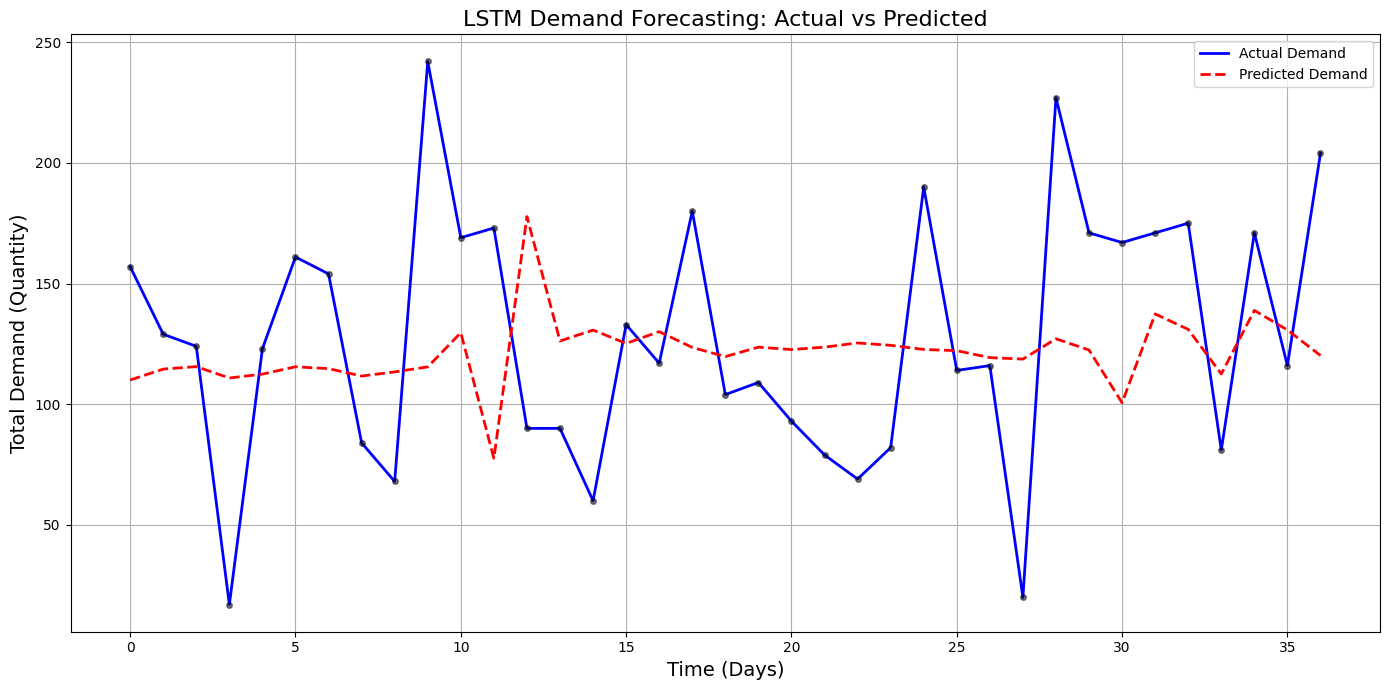

In [7]:
import matplotlib.pyplot as plt

# Inverse transform the actual test values (y_test) and predicted values (y_pred_lstm_rescaled)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted demand
plt.figure(figsize=(14, 7))

# Plotting the actual values (for test data)
plt.plot(y_test_rescaled, label="Actual Demand", color='blue', linestyle='-', linewidth=2)

# Plotting the predicted values (for test data)
plt.plot(y_pred_lstm_rescaled, label="Predicted Demand", color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('LSTM Demand Forecasting: Actual vs Predicted', fontsize=16)
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Total Demand (Quantity)', fontsize=14)

# Highlight the gap or differences visually (if needed)
for i in range(len(y_test_rescaled)):
    if y_test_rescaled[i] != y_pred_lstm_rescaled[i]:
        plt.plot(i, y_test_rescaled[i], marker='o', color='black', markersize=4, alpha=0.5)

# Show the legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
